In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model


# Define the paths to the image directories

train_img_dir = '/content/drive/MyDrive/dataset2/triple_mnist/train'
val_img_dir = '/content/drive/MyDrive/dataset2/triple_mnist/val'
test_img_dir = '/content/drive/MyDrive/dataset2/triple_mnist/test'



In [ ]:


# Function to load and preprocess images and extract labels from directory names
def load_and_preprocess_images_from_directories(base_dir, img_size=(28, 28)):
    images = []
    labels = []

    # Iterate over each directory (which represents a label)
    for label_dir in os.listdir(base_dir):
        label_dir_path = os.path.join(base_dir, label_dir)

        if os.path.isdir(label_dir_path):  # Ensure it's a directory
            # Extract labels from the directory name
            label_str = label_dir
            label = [int(digit) for digit in label_str]

            # Iterate over each image in the directory
            for filename in os.listdir(label_dir_path):
                if filename.endswith(".png"):  # Assuming images are .png files
                    img_path = os.path.join(label_dir_path, filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
                    img = cv2.resize(img, img_size)  # Resize image
                    img = img / 255.0  # Normalize pixel values
                    images.append(img)
                    labels.append(label)  # Append the label for each image

    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1)
    labels = np.array(labels)  # This should be a 2D array now with shape (num_samples, 3)

    return images, labels

In [ ]:

# Load and preprocess images
X_train, y_train = load_and_preprocess_images_from_directories(train_img_dir)
X_val, y_val = load_and_preprocess_images_from_directories(val_img_dir)
X_test, y_test = load_and_preprocess_images_from_directories(test_img_dir)

# Convert labels to categorical (for multi-class classification)
y_train_digit1 = to_categorical(y_train[:, 0], num_classes=10)
y_train_digit2 = to_categorical(y_train[:, 1], num_classes=10)
y_train_digit3 = to_categorical(y_train[:, 2], num_classes=10)

y_val_digit1 = to_categorical(y_val[:, 0], num_classes=10)
y_val_digit2 = to_categorical(y_val[:, 1], num_classes=10)
y_val_digit3 = to_categorical(y_val[:, 2], num_classes=10)

y_test_digit1 = to_categorical(y_test[:, 0], num_classes=10)
y_test_digit2 = to_categorical(y_test[:, 1], num_classes=10)
y_test_digit3 = to_categorical(y_test[:, 2], num_classes=10)

def build_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Convolutional layers
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    # Output layers for each digit
    digit1_output = layers.Dense(10, activation='softmax', name='digit1_output')(x)
    digit2_output = layers.Dense(10, activation='softmax', name='digit2_output')(x)
    digit3_output = layers.Dense(10, activation='softmax', name='digit3_output')(x)

    model = models.Model(inputs=inputs, outputs=[digit1_output, digit2_output, digit3_output])
    return model

In [ ]:

# Build and compile the model
model = build_model(input_shape=(28, 28, 1))

model.compile(optimizer=Adam,
              loss={
                  'digit1_output': 'categorical_crossentropy',
                  'digit2_output': 'categorical_crossentropy',
                  'digit3_output': 'categorical_crossentropy'
              },
              metrics={
                  'digit1_output': ['accuracy'],
                  'digit2_output': ['accuracy'],
                  'digit3_output': ['accuracy']
              })

In [ ]:
# Train the model
history = model.fit(X_train,
                    {'digit1_output': y_train_digit1,
                     'digit2_output': y_train_digit2,
                     'digit3_output': y_train_digit3},
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val,
                                     {'digit1_output': y_val_digit1,
                                      'digit2_output': y_val_digit2,
                                      'digit3_output': y_val_digit3}),
                    verbose=1)



Epoch 1/50
2001/2001 [==============================] - 23s 11ms/step - loss: 5.7656 - digit1_output_loss: 1.9522 - digit2_output_loss: 1.7807 - digit3_output_loss: 2.0327 - digit1_output_accuracy: 0.2784 - digit2_output_accuracy: 0.3656 - digit3_output_accuracy: 0.2536 - val_loss: 4.6888 - val_digit1_output_loss: 1.6768 - val_digit2_output_loss: 1.2718 - val_digit3_output_loss: 1.7401 - val_digit1_output_accuracy: 0.3741 - val_digit2_output_accuracy: 0.5527 - val_digit3_output_accuracy: 0.3644
Epoch 2/50
2001/2001 [==============================] - 21s 11ms/step - loss: 3.8137 - digit1_output_loss: 1.3242 - digit2_output_loss: 1.0361 - digit3_output_loss: 1.4534 - digit1_output_accuracy: 0.5437 - digit2_output_accuracy: 0.6516 - digit3_output_accuracy: 0.4804 - val_loss: 3.3846 - val_digit1_output_loss: 1.1901 - val_digit2_output_loss: 0.8604 - val_digit3_output_loss: 1.3341 - val_digit1_output_accuracy: 0.5854 - val_digit2_output_accuracy: 0.7146 - val_digit3_output_accuracy: 0.5140


In [ ]:
# Evaluate on the validation set
val_results = model.evaluate(
    X_val,
    {'digit1_output': y_val_digit1,
     'digit2_output': y_val_digit2,
     'digit3_output': y_val_digit3}
)

val_loss = val_results[0]
val_digit1_acc = val_results[1]
val_digit2_acc = val_results[2]
val_digit3_acc = val_results[3]

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Digit 1 Accuracy: {val_digit1_acc:.4f}")
print(f"Validation Digit 2 Accuracy: {val_digit2_acc:.4f}")
print(f"Validation Digit 3 Accuracy: {val_digit3_acc:.4f}")

500/500 [==============================] - 2s 3ms/step - loss: 0.9668 - digit1_output_loss: 0.3256 - digit2_output_loss: 0.2682 - digit3_output_loss: 0.3731 - digit1_output_accuracy: 0.9004 - digit2_output_accuracy: 0.9184 - digit3_output_accuracy: 0.8838
Validation Loss: 0.9668
Validation Digit 1 Accuracy: 0.3256
Validation Digit 2 Accuracy: 0.2682
Validation Digit 3 Accuracy: 0.3731


In [ ]:
# Evaluate on the test set
test_results = model.evaluate(
    X_test,
    {'digit1_output': y_test_digit1,
     'digit2_output': y_test_digit2,
     'digit3_output': y_test_digit3}
)

test_loss = test_results[0]
test_digit1_acc = test_results[1]
test_digit2_acc = test_results[2]
test_digit3_acc = test_results[3]

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Digit 1 Accuracy: {test_digit1_acc:.4f}")
print(f"Test Digit 2 Accuracy: {test_digit2_acc:.4f}")
print(f"Test Digit 3 Accuracy: {test_digit3_acc:.4f}")

625/625 [==============================] - 2s 3ms/step - loss: 0.9861 - digit1_output_loss: 0.3225 - digit2_output_loss: 0.2804 - digit3_output_loss: 0.3833 - digit1_output_accuracy: 0.9015 - digit2_output_accuracy: 0.9134 - digit3_output_accuracy: 0.8816
Test Loss: 0.9861
Test Digit 1 Accuracy: 0.3225
Test Digit 2 Accuracy: 0.2804
Test Digit 3 Accuracy: 0.3833


### Fine **tunning** with hyperparameters

In [ ]:

def build_model(learning_rate=0.001, dropout_rate=0.5):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(dropout_rate))

    digit1_output = layers.Dense(10, activation='softmax', name='digit1_output')(model.output)
    digit2_output = layers.Dense(10, activation='softmax', name='digit2_output')(model.output)
    digit3_output = layers.Dense(10, activation='softmax', name='digit3_output')(model.output)

    model = models.Model(inputs=model.input, outputs=[digit1_output, digit2_output, digit3_output])

    model.compile(optimizer='adam',
                  loss={'digit1_output': 'categorical_crossentropy',
                        'digit2_output': 'categorical_crossentropy',
                        'digit3_output': 'categorical_crossentropy'},
                  metrics=['accuracy'])
    return model

Cross validation with K fold



In [ ]:

param_grid = {
    'learning_rate': [0.001, 0.0001],
    'dropout_rate': [0.4, 0.5],
    'epochs': [10, 20],
    'batch_size': [32, 64]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_val_accuracy = 0
best_params = None

for learning_rate in param_grid['learning_rate']:
    for dropout_rate in param_grid['dropout_rate']:
        for batch_size in param_grid['batch_size']:
            for epochs in param_grid['epochs']:
                val_accuracy_list = []

                for train_index, val_index in kf.split(X_train):
                    model = build_model(learning_rate, dropout_rate)
                    history = model.fit(X_train[train_index],
                                        {'digit1_output': y_train_digit1[train_index],
                                         'digit2_output': y_train_digit2[train_index],
                                         'digit3_output': y_train_digit3[train_index]},
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        validation_data=(X_train[val_index],
                                                         {'digit1_output': y_train_digit1[val_index],
                                                          'digit2_output': y_train_digit2[val_index],
                                                          'digit3_output': y_train_digit3[val_index]}),
                                        verbose=1)

                    val_results = model.evaluate(
                        X_train[val_index],
                        {'digit1_output': y_train_digit1[val_index],
                         'digit2_output': y_train_digit2[val_index],
                         'digit3_output': y_train_digit3[val_index]},
                        verbose=1
                    )

                    # Unpack the results
                    val_loss = val_results[0]  # Total loss
                    digit1_loss = val_results[1]  # Loss for digit1_output
                    digit2_loss = val_results[2]  # Loss for digit2_output
                    digit3_loss = val_results[3]  # Loss for digit3_output
                    val_acc_digit1 = val_results[4]  # Accuracy for digit1_output
                    val_acc_digit2 = val_results[5]  # Accuracy for digit2_output
                    val_acc_digit3 = val_results[6]  # Accuracy for digit3_output

                    # Calculate average validation accuracy
                    val_accuracy = (val_acc_digit1 + val_acc_digit2 + val_acc_digit3) / 3
                    val_accuracy_list.append(val_accuracy)

                avg_val_accuracy = np.mean(val_accuracy_list)

                if avg_val_accuracy > best_val_accuracy:
                    best_val_accuracy = avg_val_accuracy
                    best_params = {
                        'learning_rate': learning_rate,
                        'dropout_rate': dropout_rate,
                        'batch_size': batch_size,
                        'epochs': epochs
                    }

print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
# by mistake cleaned up the output of this cell

In [ ]:
# reprinting the best hyperparameters and the best validation accuracy
print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

Best Hyperparameters: {'learning_rate': 0.001, 'dropout_rate': 0.4, 'batch_size': 32, 'epochs': 20}
Best Validation Accuracy: 0.9358


In [ ]:
final_model = build_model(learning_rate=best_params['learning_rate'], dropout_rate=best_params['dropout_rate'])
history = final_model.fit(X_train,
                          {'digit1_output': y_train_digit1,
                           'digit2_output': y_train_digit2,
                           'digit3_output': y_train_digit3},
                          epochs=best_params['epochs'],
                          batch_size=best_params['batch_size'],
                          validation_data=(X_val,
                                           {'digit1_output': y_val_digit1,
                                            'digit2_output': y_val_digit2,
                                            'digit3_output': y_val_digit3}),
                          verbose=1)

Epoch 1/20
2001/2001 [==============================] - 40s 19ms/step - loss: 3.1833 - digit1_output_loss: 0.9968 - digit2_output_loss: 0.8809 - digit3_output_loss: 1.1485 - digit1_output_accuracy: 0.6416 - digit2_output_accuracy: 0.6911 - digit3_output_accuracy: 0.5815 - val_loss: 1.6694 - val_digit1_output_loss: 0.4654 - val_digit2_output_loss: 0.4089 - val_digit3_output_loss: 0.6042 - val_digit1_output_accuracy: 0.8525 - val_digit2_output_accuracy: 0.8710 - val_digit3_output_accuracy: 0.7941
Epoch 2/20
2001/2001 [==============================] - 38s 19ms/step - loss: 1.4671 - digit1_output_loss: 0.4020 - digit2_output_loss: 0.3812 - digit3_output_loss: 0.4943 - digit1_output_accuracy: 0.8752 - digit2_output_accuracy: 0.8832 - digit3_output_accuracy: 0.8441 - val_loss: 1.2592 - val_digit1_output_loss: 0.3650 - val_digit2_output_loss: 0.3089 - val_digit3_output_loss: 0.4019 - val_digit1_output_accuracy: 0.8880 - val_digit2_output_accuracy: 0.9020 - val_digit3_output_accuracy: 0.8764


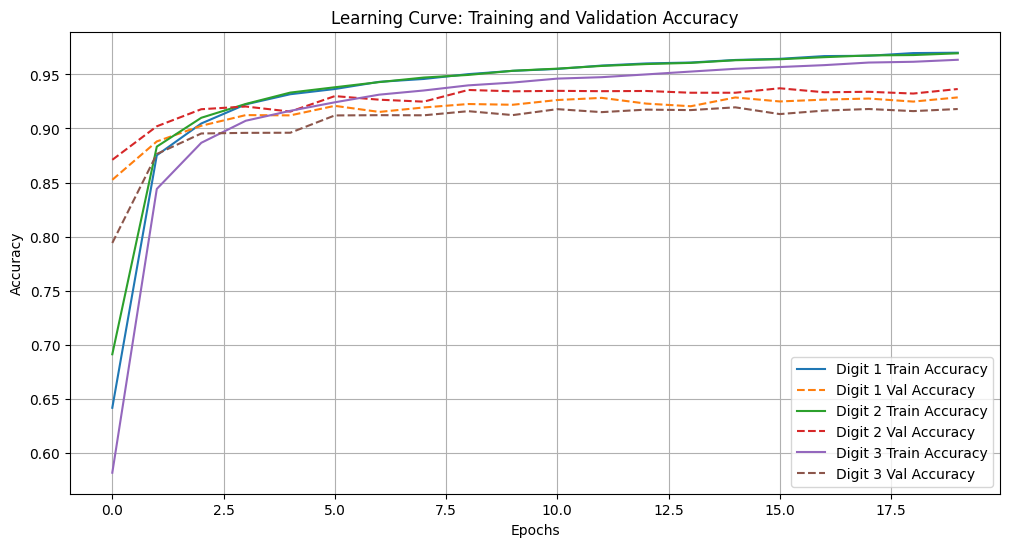

In [ ]:
# Plotting the learning curve (accuracy)
plt.figure(figsize=(12, 6))

# Summarize history for accuracy
plt.plot(history.history['digit1_output_accuracy'], label='Digit 1 Train Accuracy')
plt.plot(history.history['val_digit1_output_accuracy'], label='Digit 1 Val Accuracy', linestyle='--')
plt.plot(history.history['digit2_output_accuracy'], label='Digit 2 Train Accuracy')
plt.plot(history.history['val_digit2_output_accuracy'], label='Digit 2 Val Accuracy', linestyle='--')
plt.plot(history.history['digit3_output_accuracy'], label='Digit 3 Train Accuracy')
plt.plot(history.history['val_digit3_output_accuracy'], label='Digit 3 Val Accuracy', linestyle='--')

plt.title('Learning Curve: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



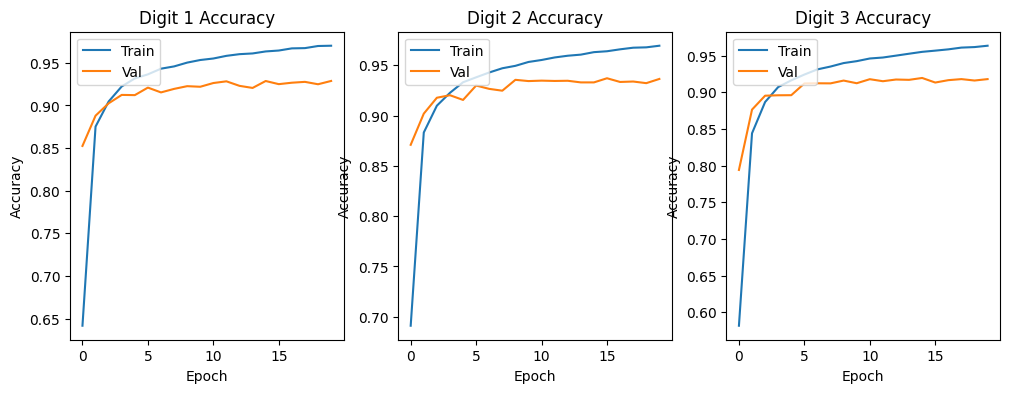

In [ ]:
# Plot training & validation accuracy values
def plot_history_split_by_digit(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['digit1_output_accuracy'])
    plt.plot(history.history['val_digit1_output_accuracy'])
    plt.title('Digit 1 Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.subplot(1, 3, 2)
    plt.plot(history.history['digit2_output_accuracy'])
    plt.plot(history.history['val_digit2_output_accuracy'])
    plt.title('Digit 2 Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.subplot(1, 3, 3)
    plt.plot(history.history['digit3_output_accuracy'])
    plt.plot(history.history['val_digit3_output_accuracy'])
    plt.title('Digit 3 Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.show()

plot_history_split_by_digit(history)


In [ ]:
test_results = final_model.evaluate(
    X_test,
    {'digit1_output': y_test_digit1,
     'digit2_output': y_test_digit2,
     'digit3_output': y_test_digit3},
    verbose=1
)

# Unpack the test results
test_loss = test_results[0]
digit1_test_loss = test_results[1]
digit2_test_loss = test_results[2]
digit3_test_loss = test_results[3]
digit1_test_acc = test_results[4]
digit2_test_acc = test_results[5]
digit3_test_acc = test_results[6]

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Digit 1 Loss: {digit1_test_loss:.4f}")
print(f"Test Digit 2 Loss: {digit2_test_loss:.4f}")
print(f"Test Digit 3 Loss: {digit3_test_loss:.4f}")
print(f"Test Digit 1 Accuracy: {digit1_test_acc:.4f}")
print(f"Test Digit 2 Accuracy: {digit2_test_acc:.4f}")
print(f"Test Digit 3 Accuracy: {digit3_test_acc:.4f}")


625/625 [==============================] - 4s 6ms/step - loss: 1.0968 - digit1_output_loss: 0.2962 - digit2_output_loss: 0.2764 - digit3_output_loss: 0.3627 - digit1_output_accuracy: 0.9278 - digit2_output_accuracy: 0.9331 - digit3_output_accuracy: 0.9115
Test Loss: 1.0968
Test Digit 1 Loss: 0.2962
Test Digit 2 Loss: 0.2764
Test Digit 3 Loss: 0.3627
Test Digit 1 Accuracy: 0.9278
Test Digit 2 Accuracy: 0.9331
Test Digit 3 Accuracy: 0.9115


In [ ]:
# F1-score

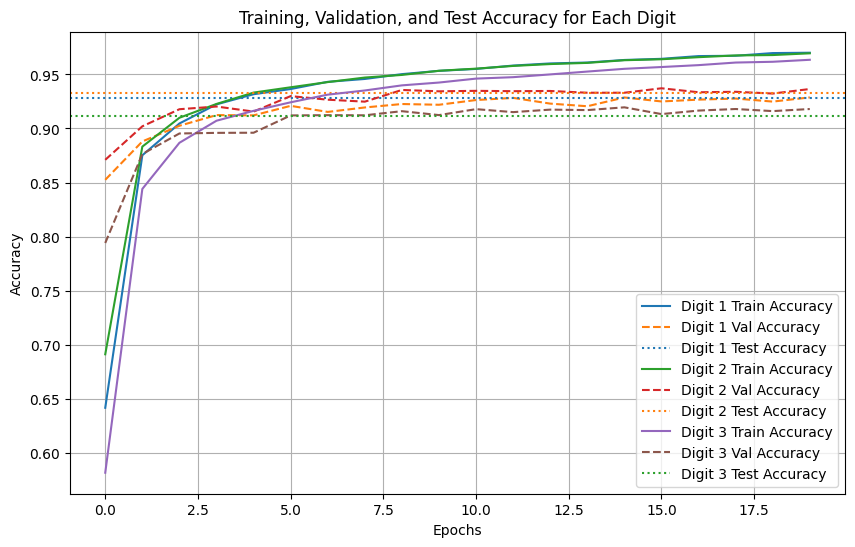

In [ ]:
# Extract accuracy metrics for all digits from the history object
train_accuracies = [history.history[f'digit{i}_output_accuracy'] for i in range(1, 4)]
val_accuracies = [history.history[f'val_digit{i}_output_accuracy'] for i in range(1, 4)]
test_accuracies = [digit1_test_acc, digit2_test_acc, digit3_test_acc]

# Plotting the accuracy for each digit
plt.figure(figsize=(10, 6))

for i in range(3):
    plt.plot(train_accuracies[i], label=f'Digit {i+1} Train Accuracy')
    plt.plot(val_accuracies[i], label=f'Digit {i+1} Val Accuracy', linestyle='--')
    plt.axhline(y=test_accuracies[i], color=f'C{i}', linestyle=':', label=f'Digit {i+1} Test Accuracy')

plt.title('Training, Validation, and Test Accuracy for Each Digit')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()